In [1]:
#1º TENTATIVA 
import pandas as pd
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

#Função para extrair features físico-químicas
def extract_features(sequence):
    analysed = ProteinAnalysis(sequence)
    return {
        "length": len(sequence),
        "molecular_weight": analysed.molecular_weight(),
        "aromaticity": analysed.aromaticity(),
        "instability_index": analysed.instability_index(),
        "isoelectric_point": analysed.isoelectric_point(),
        "gravy": analysed.gravy()
    }

# Ler ficheiros FASTA
def read_fasta_labeled(filepath, label):
    data = []
    with open(filepath, 'r') as f:
        seq = ""
        for line in f:
            if line.startswith(">"):
                if seq:
                    data.append({"sequence": seq, "label": label})
                    seq = ""
            else:
                seq += line.strip()
        if seq:
            data.append({"sequence": seq, "label": label})
    return pd.DataFrame(data)

##Preparação do dataset
df_pos = read_fasta_labeled(r"C:\Users\filip\Bioinformática\Semestre 2\Projeto\Re_ cnt maquina virtual\conjunto_positivos_am.fasta", 1)
df_neg = read_fasta_labeled(r"C:\Users\filip\Bioinformática\Semestre 2\Projeto\Re_ cnt maquina virtual\conjunto_negativos_am.fasta", 0)
df = pd.concat([df_pos, df_neg], ignore_index=True)

features = df["sequence"].apply(extract_features).apply(pd.Series)
df_final = pd.concat([features, df["label"]], axis=1)

df_final.to_csv("dataset_am.csv", index=False)

#Normalização e divisão treino-teste (90/10)
X = df_final.drop("label", axis=1)
y = df_final["label"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.1, stratify=y, random_state=42)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

#Avaliação dos modelos
def avaliar_modelo(modelo, nome):
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    print(f"\n{nome}")
    print("Matriz de Confusão:")
    print(confusion_matrix(y_test, y_pred))
    print("F1-score:", f1_score(y_test, y_pred))
    print("Relatório de Classificação:")
    print(classification_report(y_test, y_pred))

    scores = cross_val_score(modelo, X_train, y_train, cv=skf, scoring="f1")
    print("F1-score médio (10-fold CV no treino):", scores.mean())
    
avaliar_modelo(SVC(kernel="linear", probability=True), "SVM")
avaliar_modelo(RandomForestClassifier(random_state=42), "Random Forest")
avaliar_modelo(GaussianNB(), "Gaussian Naive Bayes")


SVM
Matriz de Confusão:
[[389   0]
 [162   0]]
F1-score: 0.0
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83       389
           1       0.00      0.00      0.00       162

    accuracy                           0.71       551
   macro avg       0.35      0.50      0.41       551
weighted avg       0.50      0.71      0.58       551



c:\Users\filip\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\filip\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\filip\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


F1-score médio (10-fold CV no treino): 0.0

Random Forest
Matriz de Confusão:
[[363  26]
 [118  44]]
F1-score: 0.3793103448275862
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.75      0.93      0.83       389
           1       0.63      0.27      0.38       162

    accuracy                           0.74       551
   macro avg       0.69      0.60      0.61       551
weighted avg       0.72      0.74      0.70       551

F1-score médio (10-fold CV no treino): 0.3457330658695147

Gaussian Naive Bayes
Matriz de Confusão:
[[299  90]
 [100  62]]
F1-score: 0.39490445859872614
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       389
           1       0.41      0.38      0.39       162

    accuracy                           0.66       551
   macro avg       0.58      0.58      0.58       551
weighted avg       0.65      0.66      0.65       551

F1-scor

In [1]:
#2º TENTATIVA COM APLICAÇÃO DE SMOTE (OVERSAMPLING)
import pandas as pd
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE

# Função para extrair features físico-químicas
def extract_features(sequence):
    analysed = ProteinAnalysis(sequence)
    return {
        "length": len(sequence),
        "molecular_weight": analysed.molecular_weight(),
        "aromaticity": analysed.aromaticity(),
        "instability_index": analysed.instability_index(),
        "isoelectric_point": analysed.isoelectric_point(),
        "gravy": analysed.gravy()
    }

# Ler ficheiros FASTA com labels
def read_fasta_labeled(filepath, label):
    data = []
    with open(filepath, 'r') as f:
        seq = ""
        for line in f:
            if line.startswith(">"):
                if seq:
                    data.append({"sequence": seq, "label": label})
                    seq = ""
            else:
                seq += line.strip()
        if seq:
            data.append({"sequence": seq, "label": label})
    return pd.DataFrame(data)

# Preparação do dataset
df_pos = read_fasta_labeled(r"C:\Users\filip\Bioinformática\Semestre 2\Projeto\Re_ cnt maquina virtual\conjunto_positivos_am.fasta", 1)
df_neg = read_fasta_labeled(r"C:\Users\filip\Bioinformática\Semestre 2\Projeto\Re_ cnt maquina virtual\conjunto_negativos_am.fasta", 0)
df = pd.concat([df_pos, df_neg], ignore_index=True)

features = df["sequence"].apply(extract_features).apply(pd.Series)
df_final = pd.concat([features, df["label"]], axis=1)
df_final.to_csv("dataset_am.csv", index=False)

# Normalização e divisão treino-teste (90/10)
X = df_final.drop("label", axis=1)
y = df_final["label"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.1, stratify=y, random_state=42)

# Aplicar SMOTE ao conjunto de treino
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Função de avaliação comum
def avaliar_modelo(modelo, nome):
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    print(f"\n {nome}")
    print("Matriz de Confusão:")
    print(confusion_matrix(y_test, y_pred))
    print("F1-score:", f1_score(y_test, y_pred))
    print("Relatório de Classificação:")
    print(classification_report(y_test, y_pred))

    scores = cross_val_score(modelo, X_train, y_train, cv=skf, scoring="f1")
    print("F1-score médio (10-fold CV no treino):", scores.mean())

# Avaliação dos modelos
avaliar_modelo(SVC(kernel="linear", probability=True), "SVM")
avaliar_modelo(RandomForestClassifier(random_state=42), "Random Forest")
avaliar_modelo(GaussianNB(), "Gaussian Naive Bayes")



 SVM
Matriz de Confusão:
[[235 154]
 [ 76  86]]
F1-score: 0.42786069651741293
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.76      0.60      0.67       389
           1       0.36      0.53      0.43       162

    accuracy                           0.58       551
   macro avg       0.56      0.57      0.55       551
weighted avg       0.64      0.58      0.60       551

F1-score médio (10-fold CV no treino): 0.588720761562949

 Random Forest
Matriz de Confusão:
[[302  87]
 [ 83  79]]
F1-score: 0.4817073170731707
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78       389
           1       0.48      0.49      0.48       162

    accuracy                           0.69       551
   macro avg       0.63      0.63      0.63       551
weighted avg       0.69      0.69      0.69       551

F1-score médio (10-fold CV no treino): 0.7889645028249763

 Gaussi


SVM
Matriz de Confusão:
[[235 154]
 [ 76  86]]
F1-score: 0.42786069651741293
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.76      0.60      0.67       389
           1       0.36      0.53      0.43       162

    accuracy                           0.58       551
   macro avg       0.56      0.57      0.55       551
weighted avg       0.64      0.58      0.60       551

F1-score médio (10-fold CV no treino): 0.588720761562949

Random Forest
Matriz de Confusão:
[[302  87]
 [ 83  79]]
F1-score: 0.4817073170731707
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78       389
           1       0.48      0.49      0.48       162

    accuracy                           0.69       551
   macro avg       0.63      0.63      0.63       551
weighted avg       0.69      0.69      0.69       551

F1-score médio (10-fold CV no treino): 0.7889645028249763

Gaussian 

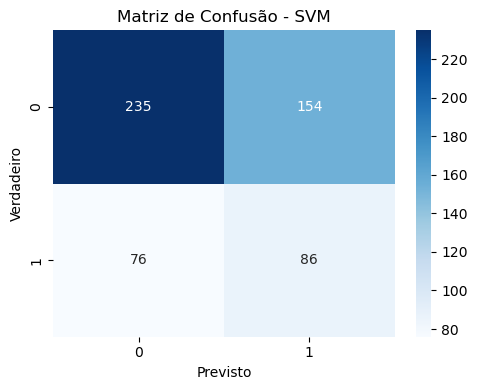

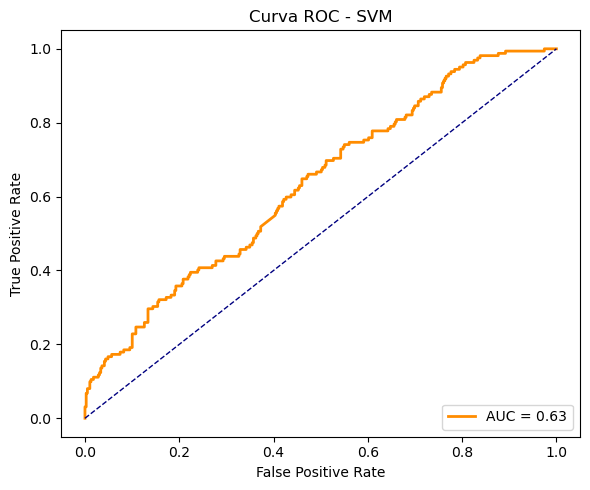


Avaliação Random Forest
              precision    recall  f1-score   support

           0       0.78      0.78      0.78       389
           1       0.48      0.49      0.48       162

    accuracy                           0.69       551
   macro avg       0.63      0.63      0.63       551
weighted avg       0.69      0.69      0.69       551

F1-score: 0.4817073170731707


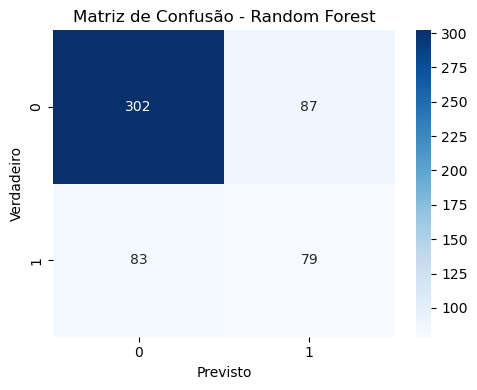

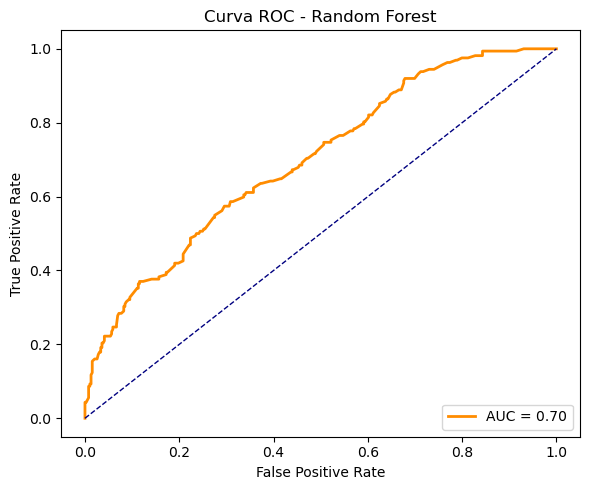


Avaliação Gaussian Naive Bayes
              precision    recall  f1-score   support

           0       0.80      0.18      0.29       389
           1       0.31      0.90      0.46       162

    accuracy                           0.39       551
   macro avg       0.56      0.54      0.38       551
weighted avg       0.66      0.39      0.34       551

F1-score: 0.4625199362041467


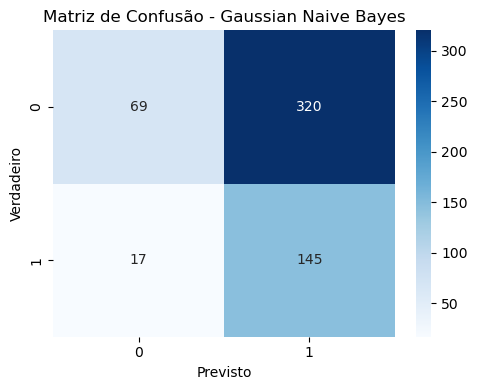

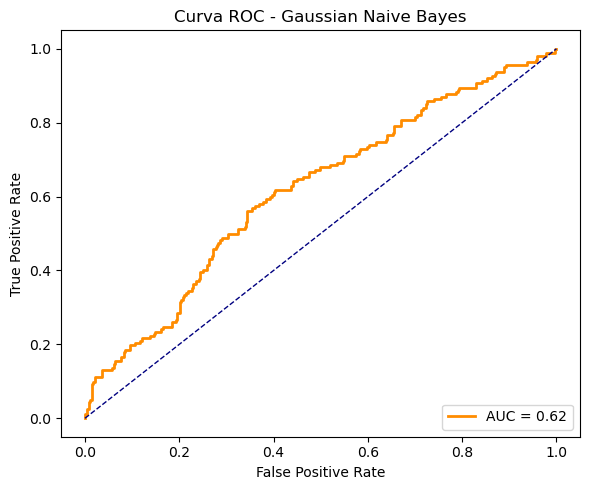

In [2]:
#ANÁLISE DE FEATURES
import pandas as pd
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

#Extração das features
def extract_features(sequence):
    analysed = ProteinAnalysis(sequence)
    return {
        "length": len(sequence),
        "molecular_weight": analysed.molecular_weight(),
        "aromaticity": analysed.aromaticity(),
        "instability_index": analysed.instability_index(),
        "isoelectric_point": analysed.isoelectric_point(),
        "gravy": analysed.gravy()
    }

# Ler ficheiros FASTA
def read_fasta_labeled(filepath, label):
    data = []
    with open(filepath, 'r') as f:
        seq = ""
        for line in f:
            if line.startswith(">"):
                if seq:
                    data.append({"sequence": seq, "label": label})
                    seq = ""
            else:
                seq += line.strip()
        if seq:
            data.append({"sequence": seq, "label": label})
    return pd.DataFrame(data)

#Preparação do dataset
df_pos = read_fasta_labeled(r"C:\Users\filip\Bioinformática\Semestre 2\Projeto\Re_ cnt maquina virtual\conjunto_positivos_am.fasta", 1)
df_neg = read_fasta_labeled(r"C:\Users\filip\Bioinformática\Semestre 2\Projeto\Re_ cnt maquina virtual\conjunto_negativos_am.fasta", 0)
df = pd.concat([df_pos, df_neg], ignore_index=True)

features = df["sequence"].apply(extract_features).apply(pd.Series)
df_final = pd.concat([features, df["label"]], axis=1)
df_final.to_csv("dataset_am.csv", index=False)

#Normalização e divisão treino-teste (90/10)
X = df_final.drop("label", axis=1)
y = df_final["label"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.1, stratify=y, random_state=42)

sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

#Avaliação dos modelos
def avaliar_modelo(modelo, nome):
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    print(f"\n{nome}")
    print("Matriz de Confusão:")
    print(confusion_matrix(y_test, y_pred))
    print("F1-score:", f1_score(y_test, y_pred))
    print("Relatório de Classificação:")
    print(classification_report(y_test, y_pred))

    scores = cross_val_score(modelo, X_train, y_train, cv=skf, scoring="f1")
    print("F1-score médio (10-fold CV no treino):", scores.mean())

avaliar_modelo(SVC(kernel="linear", probability=True), "SVM")
avaliar_modelo(RandomForestClassifier(random_state=42), "Random Forest")
avaliar_modelo(GaussianNB(), "Gaussian Naive Bayes")

#CRIAÇÃO DA MATRIZ DE CONFUSÃO, ROC-AUC
svm = SVC(kernel="linear", probability=True, class_weight="balanced", random_state=42)
rf = RandomForestClassifier(random_state=42, class_weight="balanced")
gnb = GaussianNB()

svm.fit(X_train, y_train)
rf.fit(X_train, y_train)
gnb.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)
y_score_svm = svm.predict_proba(X_test)[:, 1]

y_pred_rf = rf.predict(X_test)
y_score_rf = rf.predict_proba(X_test)[:, 1]

y_pred_gnb = gnb.predict(X_test)
y_score_gnb = gnb.predict_proba(X_test)[:, 1]

# Gráficos
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de Confusão - {title}")
    plt.xlabel("Previsto")
    plt.ylabel("Verdadeiro")
    plt.tight_layout()
    plt.show()

def plot_roc(y_true, y_score, title):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Curva ROC - {title}")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

# Avaliação e visualização
print("\nAvaliação SVM")
print(classification_report(y_test, y_pred_svm))
print("F1-score:", f1_score(y_test, y_pred_svm))
plot_confusion(y_test, y_pred_svm, "SVM")
plot_roc(y_test, y_score_svm, "SVM")

print("\nAvaliação Random Forest")
print(classification_report(y_test, y_pred_rf))
print("F1-score:", f1_score(y_test, y_pred_rf))
plot_confusion(y_test, y_pred_rf, "Random Forest")
plot_roc(y_test, y_score_rf, "Random Forest")

print("\nAvaliação Gaussian Naive Bayes")
print(classification_report(y_test, y_pred_gnb))
print("F1-score:", f1_score(y_test, y_pred_gnb))
plot_confusion(y_test, y_pred_gnb, "Gaussian Naive Bayes")
plot_roc(y_test, y_score_gnb, "Gaussian Naive Bayes")


In [3]:
#VERIFICAÇÃO DA ESTRUTURA DO FICHEIRO FASTA
from Bio import SeqIO

with open(r"C:\Users\filip\Bioinformática\Semestre 2\Projeto\drugbank_all_target_polypeptide_sequences.fasta\protein.fasta") as f:
    records = list(SeqIO.parse(f, "fasta"))

print(f"Total de sequências: {len(records)}")

for rec in records[:3]:
    print(f"ID: {rec.id}")
    print(f"Descrição: {rec.description}")
    print(f"Seq (50 aa): {str(rec.seq)[:50]}")
    


Total de sequências: 5529
ID: drugbank_target|P45059
Descrição: drugbank_target|P45059 Peptidoglycan synthase FtsI (DB00303)
Seq (50 aa): MVKFNSSRKSGKSKKTIRKLTAPETVKQNKPQKVFEKCFMRGRYMLSTVL
ID: drugbank_target|P19113
Descrição: drugbank_target|P19113 Histidine decarboxylase (DB00114; DB00117; DB06666)
Seq (50 aa): MMEPEEYRERGREMVDYICQYLSTVRERRVTPDVQPGYLRAQLPESAPED
ID: drugbank_target|Q9UI32
Descrição: drugbank_target|Q9UI32 Glutaminase liver isoform, mitochondrial (DB00142; DB15232)
Seq (50 aa): MRSMKALQKALSRAGSHCGRGGWGHPSRSPLLGGGVRHHLSEAAAQGRET


In [4]:
#TESTE COM DADOS ANTITUMORAIS COM MODELO RANDOM FOREST
import pandas as pd
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import re

#Preparação dos dados
data = []
for record in SeqIO.parse(r"C:\Users\filip\Bioinformática\Semestre 2\Projeto\drugbank_all_target_polypeptide_sequences.fasta\protein.fasta", "fasta"):
    data.append({
        "id": record.id,
        "description": record.description,
        "sequence": str(record.seq)
    })
df_prot = pd.DataFrame(data)

df_tumor = pd.read_csv(r"C:\Users\filip\Bioinformática\Semestre 2\Projeto\Re_ cnt maquina virtual\drugbank_antitumorais.csv")
drug_ids = set(df_tumor["drugbank_id"].dropna().str.upper().unique())

def extract_ids(description):
    return re.findall(r"(DB\d{5})", description)

df_prot["drugbank_ids"] = df_prot["description"].apply(extract_ids)

#Filtração de sequências
df_prot["match"] = df_prot["drugbank_ids"].apply(lambda ids: any(dbid in drug_ids for dbid in ids))
df_targets = df_prot[df_prot["match"]].copy()

print(f"{len(df_targets)} sequências correspondentes a targets antitumorais encontradas.")

#Extrair features
def extract_features(seq):
    analysed = ProteinAnalysis(seq)
    return {
        "length": len(seq),
        "molecular_weight": analysed.molecular_weight(),
        "aromaticity": analysed.aromaticity(),
        "instability_index": analysed.instability_index(),
        "isoelectric_point": analysed.isoelectric_point(),
        "gravy": analysed.gravy()
    }

features = []
ids = []
for _, row in df_targets.iterrows():
    try:
        f = extract_features(row["sequence"])
        features.append(f)
        ids.append(row["id"])
    except Exception as e:
        print(f"Erro em {row['id']}: {e}")

df_feat = pd.DataFrame(features)
df_feat["target_id"] = ids

#Treino do modelo RF
df_train = pd.read_csv(r"C:\Users\filip\Bioinformática\Semestre 2\Projeto\dataset_am.csv")
X_train = df_train.drop("label", axis=1)
y_train = df_train["label"]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

model = RandomForestClassifier(random_state=42, class_weight="balanced")
model.fit(X_train_scaled, y_train)

#Teste do modelo com os dados antitumorais
X_new = scaler.transform(df_feat.drop("target_id", axis=1))
df_feat["prediction"] = model.predict(X_new)
df_feat["probabilidade"] = model.predict_proba(X_new)[:, 1]

#Criar dataframe final
df_feat[["target_id", "prediction", "probabilidade"]].to_csv("previsões_antitumorais_RF.csv", index=False)


1589 sequências correspondentes a targets antitumorais encontradas.
Erro em drugbank_target|P07203: 'U'
Erro em drugbank_target|Q16881: 'U'
Erro em drugbank_target|Q9NNW7: 'U'
Erro em drugbank_target|P49908: 'U'


In [5]:

# TESTE COM DADOS ANTITUMORAIS COM MODELO SVM
import pandas as pd
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import re

# Preparação dos dados
data = []
for record in SeqIO.parse(r"C:\Users\filip\Bioinformática\Semestre 2\Projeto\drugbank_all_target_polypeptide_sequences.fasta\protein.fasta", "fasta"):
    data.append({
        "id": record.id,
        "description": record.description,
        "sequence": str(record.seq)
    })
df_prot = pd.DataFrame(data)

df_tumor = pd.read_csv(r"C:\Users\filip\Bioinformática\Semestre 2\Projeto\Re_ cnt maquina virtual\drugbank_antitumorais.csv")
drug_ids = set(df_tumor["drugbank_id"].dropna().str.upper().unique())

def extract_ids(description):
    return re.findall(r"(DB\d{5})", description)

df_prot["drugbank_ids"] = df_prot["description"].apply(extract_ids)
df_prot["match"] = df_prot["drugbank_ids"].apply(lambda ids: any(dbid in drug_ids for dbid in ids))
df_targets = df_prot[df_prot["match"]].copy()

print(f"{len(df_targets)} sequências correspondentes a targets antitumorais encontradas.")

def extract_features(seq):
    analysed = ProteinAnalysis(seq)
    return {
        "length": len(seq),
        "molecular_weight": analysed.molecular_weight(),
        "aromaticity": analysed.aromaticity(),
        "instability_index": analysed.instability_index(),
        "isoelectric_point": analysed.isoelectric_point(),
        "gravy": analysed.gravy()
    }

features = []
ids = []
for _, row in df_targets.iterrows():
    try:
        f = extract_features(row["sequence"])
        features.append(f)
        ids.append(row["id"])
    except Exception as e:
        print(f"Erro em {row['id']}: {e}")

df_feat = pd.DataFrame(features)
df_feat["target_id"] = ids

# Treino com SVM
df_train = pd.read_csv(r"C:\Users\filip\Bioinformática\Semestre 2\Projeto\dataset_am.csv")
X_train = df_train.drop("label", axis=1)
y_train = df_train["label"]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

model = SVC(kernel="linear", probability=True, class_weight="balanced", random_state=42)
model.fit(X_train_scaled, y_train)

X_new = scaler.transform(df_feat.drop("target_id", axis=1))
df_feat["prediction"] = model.predict(X_new)
df_feat["probabilidade"] = model.predict_proba(X_new)[:, 1]

df_feat[["target_id", "prediction", "probabilidade"]].to_csv("previsões_antitumorais_SVM.csv", index=False)


1589 sequências correspondentes a targets antitumorais encontradas.
Erro em drugbank_target|P07203: 'U'
Erro em drugbank_target|Q16881: 'U'
Erro em drugbank_target|Q9NNW7: 'U'
Erro em drugbank_target|P49908: 'U'


In [6]:

# TESTE COM DADOS ANTITUMORAIS USANDO GAUSSIAN NAIVE BAYES
import pandas as pd
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
import re

# Preparação dos dados
data = []
for record in SeqIO.parse(r"C:\Users\filip\Bioinformática\Semestre 2\Projeto\drugbank_all_target_polypeptide_sequences.fasta\protein.fasta", "fasta"):
    data.append({
        "id": record.id,
        "description": record.description,
        "sequence": str(record.seq)
    })
df_prot = pd.DataFrame(data)

df_tumor = pd.read_csv(r"C:\Users\filip\Bioinformática\Semestre 2\Projeto\Re_ cnt maquina virtual\drugbank_antitumorais.csv")
drug_ids = set(df_tumor["drugbank_id"].dropna().str.upper().unique())

def extract_ids(description):
    return re.findall(r"(DB\d{5})", description)

df_prot["drugbank_ids"] = df_prot["description"].apply(extract_ids)
df_prot["match"] = df_prot["drugbank_ids"].apply(lambda ids: any(dbid in drug_ids for dbid in ids))
df_targets = df_prot[df_prot["match"]].copy()

print(f"{len(df_targets)} sequências correspondentes a targets antitumorais encontradas.")

def extract_features(seq):
    analysed = ProteinAnalysis(seq)
    return {
        "length": len(seq),
        "molecular_weight": analysed.molecular_weight(),
        "aromaticity": analysed.aromaticity(),
        "instability_index": analysed.instability_index(),
        "isoelectric_point": analysed.isoelectric_point(),
        "gravy": analysed.gravy()
    }

features = []
ids = []
for _, row in df_targets.iterrows():
    try:
        f = extract_features(row["sequence"])
        features.append(f)
        ids.append(row["id"])
    except Exception as e:
        print(f"Erro em {row['id']}: {e}")

df_feat = pd.DataFrame(features)
df_feat["target_id"] = ids

# Treino com Gaussian Naive Bayes
df_train = pd.read_csv(r"C:\Users\filip\Bioinformática\Semestre 2\Projeto\dataset_am.csv")
X_train = df_train.drop("label", axis=1)
y_train = df_train["label"]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

model = GaussianNB()
model.fit(X_train_scaled, y_train)

X_new = scaler.transform(df_feat.drop("target_id", axis=1))
df_feat["prediction"] = model.predict(X_new)
df_feat["probabilidade"] = model.predict_proba(X_new)[:, 1]

df_feat[["target_id", "prediction", "probabilidade"]].to_csv("previsões_antitumorais_GNB.csv", index=False)


1589 sequências correspondentes a targets antitumorais encontradas.
Erro em drugbank_target|P07203: 'U'
Erro em drugbank_target|Q16881: 'U'
Erro em drugbank_target|Q9NNW7: 'U'
Erro em drugbank_target|P49908: 'U'
